In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import datetime
import os
import sys
import pickle

In [2]:
from discopro.grammar import tensor
from discopro.anaphora import connect_anaphora_on_top
from lambeq import BobcatParser, NumpyModel, AtomicType, Rewriter, Dataset, QuantumTrainer, SPSAOptimizer , AtomicType, IQPAnsatz, RemoveCupsRewriter, UnifyCodomainRewriter, BinaryCrossEntropyLoss
from lambeq.backend.grammar import Spider, Ty
from lambeq.backend.quantum import Box, qubit, SelfConjugate, Ry, Diagram
from contextuality.model import Model, Scenario, CyclicScenario

In [3]:
remove_cups = RemoveCupsRewriter()

parser = BobcatParser()
rewriter = Rewriter(['auxiliary',
                     'connector',
                     'coordination',
                     'determiner',
                     'object_rel_pronoun',
                     'subject_rel_pronoun',
                     'postadverb',
                     'preadverb',
                     'prepositional_phrase'])

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE 

ansatz = IQPAnsatz({N: 1, S: 1, P:1}, n_layers=1, n_single_qubit_params=3) 

In [4]:
def sent2dig(sentence1: str, sentence2: str, pro: str, ref: str, mode='default', con=True):
    diagram1 = parser.sentence2diagram(sentence1)
    diagram2 = parser.sentence2diagram(sentence2)
    diagram = tensor(diagram1, diagram2)
    
    if mode == 'spider':
        diagram = diagram >> Spider(S, 2, 1)
    elif mode == 'box':
        merger = UnifyCodomainRewriter(Ty('s'))
        diagram = merger(diagram)

    if con == True:
        pro_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == pro.casefold())
        ref_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == ref.casefold())
        diagram = connect_anaphora_on_top(diagram, pro_box_idx, ref_box_idx)
        
    rewritten_diagram = rewriter(remove_cups(diagram)).normal_form()
    return rewritten_diagram

In [5]:
def gen_labels(path: str, verbose=False):
    df = pd.read_csv(path, index_col=0)
    df = df[:100]
    
    if not os.path.exists(os.getcwd()+'/err_logs'):
        os.mkdir(os.getcwd()+'/err_logs')
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    f = open("err_logs/log_"+path.split('/')[-1].split('.')[-2]+'_'+timestamp+".txt",'w')
    
    circuits, labels, diagrams = [],[],[]
    #selected_cols = [random.choice(['referent', 'wrong_referent']) for i in range(len(df))]
    for i, row in tqdm(df.iterrows(), total=len(df), position=0, leave=True):
        #ref = row[selected_cols[i]]
        # label = [0,1] if selected_cols[i] == 'referent' else [1,0]
        #label = [[0.25, 0.25],[0.25, 0.25]]
        label = [0,1]
        sent1, sent2, pro, ref = row[['sentence1', 'sentence2', 'pronoun', 'referent']]

        try:
            diagram = sent2dig(sent1.strip(), sent2.strip(), pro.strip(), ref.strip(), mode='spider')
            diagrams.append(diagram)
            circ = ansatz(diagram)
            circuits.append(circ)
            labels.append(label)
        except Exception as err:
            tqdm.write(f"Error: {err}".strip(), file=f)
            if verbose:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
    f.close()
    
    return circuits, labels, diagrams

In [50]:
train_circuits, train_labels, train_diagrams = gen_labels('dataset/original_data/train.csv')
val_circuits, val_labels, val_diagrams = gen_labels('dataset/original_data/val.csv')
test_circuits, test_labels, test_diagrams = gen_labels('dataset/original_data/test.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


In [67]:
model = NumpyModel.from_diagrams(train_circuits + val_circuits + test_circuits, use_jit=True)
loss = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y: np.sqrt(np.mean((np.array(y_hat)-np.array(y))**2)/2)

In [54]:
SEED = random.randint(0, 1000)
BATCH_SIZE = 20
EPOCHS = 100

In [55]:
train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(val_circuits, val_labels, shuffle=True)
test_dataset = Dataset(test_circuits, test_labels)

In [70]:
trainer = QuantumTrainer(model,
                         loss_function=loss,
                         optimizer=SPSAOptimizer,
                         epochs=EPOCHS,
                         optim_hyperparams={'a': 0.1, 'c': 0.06, 'A': 0.01 * EPOCHS},
                         evaluate_functions={"err": acc},
                         evaluate_on_train=True,
                         verbose='text', 
                         seed=SEED)

In [71]:
print("Learning parameters: "+datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=1)
test_acc = acc(model(test_dataset.data[:10]), test_dataset.targets[:10])
print('Test accuracy:', test_acc)

Learning parameters: 2024-07-04_14_33_36


Epoch 1:    train/loss: 1.2972   valid/loss: 1.1715   train/err: 0.4334   valid/err: 0.4290
Epoch 2:    train/loss: 1.0510   valid/loss: 1.3518   train/err: 0.4289   valid/err: 0.4415
Epoch 3:    train/loss: 2.1089   valid/loss: 1.1869   train/err: 0.4295   valid/err: 0.4079
Epoch 4:    train/loss: 0.3932   valid/loss: 0.7364   train/err: 0.3688   valid/err: 0.3379
Epoch 5:    train/loss: 0.7539   valid/loss: 0.8877   train/err: 0.3560   valid/err: 0.3716
Epoch 6:    train/loss: 1.1157   valid/loss: 0.8964   train/err: 0.3336   valid/err: 0.3795
Epoch 7:    train/loss: 1.3176   valid/loss: 0.8889   train/err: 0.3522   valid/err: 0.3750
Epoch 8:    train/loss: 0.8923   valid/loss: 0.9537   train/err: 0.3667   valid/err: 0.3699
Epoch 9:    train/loss: 0.3370   valid/loss: 0.8621   train/err: 0.3302   valid/err: 0.3509
Epoch 10:   train/loss: 0.6955   valid/loss: 0.8894   train/err: 0.3280   valid/err: 0.3540
Epoch 11:   train/loss: 0.8693   valid/loss: 0.9064   train/err: 0.3427   valid/

Test accuracy: 0.45101258572337755


In [6]:
def train(trainer: QuantumTrainer, EPOCH_ARR: [int], BATCH_ARR: [int], SEED_N: int, train_dataset: Dataset, val_dataset: Dataset, test_dataset: Dataset):
    SEEDS = random.sample(range(1000), SEED_N)
    trainer.verbose = 'supress'
    model = trainer.model
    
    print("%0s %23s %7s %7s  %12s" % ("Time","Epochs","Batch","Seed","Accuracy"))
    for EPOCHS in EPOCH_ARR:
        for BATCH_SIZE in BATCH_ARR:
            for SEED in SEEDS:
                trainer.epochs = EPOCHS
                trainer.optim_hyperparams = {'a': 0.1, 'c': 0.06, 'A': 0.01 * EPOCHS}
                train_dataset.batch_size = BATCH_SIZE
                time = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
                print("%0s %8s %7s %7s" % (time, EPOCHS, BATCH_SIZE, SEED), end='')
                trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=1)
                test_acc = acc(model(test_dataset.data), test_dataset.targets)
                print("%14s" % (round(test_acc, 6)))

In [141]:
class data_processor:
    def __init__(self, scenario: Scenario, model_path: str=None):
        self.scenario = scenario # Measurement scenario modelling the schema

        # Data
        self.data = pd.DataFrame(columns=["Sentence", "CF", "SF", "CbD", "DI", "Violation", "Distribution"])
        self.diagrams = []
        self.sentences = []
            
        if model_path: # Model is a NumpyModel with learnt parameters of ansatz circuits
            self.model = NumpyModel.from_checkpoint(model_path)
            self.model.initialise_weights()
        else:
            self.model = None

        # Measurement basis used in max violation CHSH experiment with their matrix representations
        self.bases = {'a':Ry(0), 'A':Ry(np.pi/4), 'b':Ry(np.pi/8), 'B':Ry(3*np.pi/8)}
        self.pairs = {'ab': np.kron(Ry(0).array, Ry(np.pi/8).array),
                      'aB': np.kron(Ry(0).array, Ry(3*np.pi/8).array),
                      'Ab': np.kron(Ry(np.pi/4).array, Ry(np.pi/8).array),
                      'AB': np.kron(Ry(np.pi/4).array, Ry(3*np.pi/8).array)}

    def load_file(self, path: str) -> None | pd.DataFrame | zip:
        if not path:
            return
        elif os.path.splitext(path)[-1] == '.csv':
            return pd.read_csv(path)
        elif os.path.splitext(path)[-1] == '.pkl':
            file = open(path, 'rb')
            data =  pickle.load(file)
            file.close()
            return data
        else:
            print("Provided file doesn't match a supported type.")
            return

    def load_model(self, path: str, variant: str=None) -> None:
        self.model = NumpyModel.from_checkpoint(model_path)

    def get_data(self, path: str) -> None:
        if not path:
            return
        self.data = self.load_file(path)

    def get_diagrams(self, path: str) -> None:
        if not path:
            return
        
        schema_data = self.load_file(path)
        if os.path.splitext(path)[-1] == '.pkl':
            self.sentences, self.diagrams = zip(*schema_data)
            self.sentences = list(self.sentences)
            self.diagrams = list(self.diagrams)
            return
            
        for _, row in tqdm(schema_data.iterrows(), total=len(schema_data)):
            try:
                s1, s2, pro, ref = row[['sentence1','sentence2','pronoun','referent']]
                self.diagrams.append(ansatz(sent2dig(s1, s2, pro, ref)))
                self.sentences.append(s1 + '. ' + s2 + '.')
            except Exception as err:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
        f = open('dataset/sent_circ_pairs'+'_'+str(len(self.diagrams))+'_'+datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")+'.pkl', 'wb')
        pickle.dump(list(zip(self.sentences, self.diagrams)), f)
        f.close()

    def get_emp_model(self, diag: Diagram) -> Model:
        diag_ab = diag.apply_gate(self.bases['a'],0).apply_gate(self.bases['b'],1)
        diag_aB = diag.apply_gate(self.bases['a'],0).apply_gate(self.bases['B'],1)
        diag_Ab = diag.apply_gate(self.bases['A'],0).apply_gate(self.bases['b'],1)
        diag_AB = diag.apply_gate(self.bases['A'],0).apply_gate(self.bases['B'],1)

        pr_dist = self.model.get_diagram_output([diag_ab, diag_aB, diag_Ab, diag_AB])
        pr_dist = np.reshape(pr_dist, (4,4))
        return Model(self.scenario, pr_dist)

    def calc_violation(self, pr_dist: np.array) -> float:
        state = np.sqrt(pr_dist)
        expectations = [np.matmul(state, np.matmul(self.pairs[ops], state)) for ops in list(self.pairs.keys())]
        possible_vals = []
        for i in range(4):
            res = abs(sum(expectations) - 2*expectations[i])
            possible_vals.append(res)
        return max(possible_vals)

    def calc_ent(self, pr_dist: np.array) -> float:
        state = np.sqrt(pr_dist)
        dense = np.out(state, state)
        return -np.trace(np.matmul(dense, np.log(dense)))

    def gen_data(self) -> None:
        data_dict = {'Sentence':[], 'CF':[], 'SF':[], 'CbD':[], 'DI':[], 'Violation':[], 'Distribution': []}
        for diagram, sentence in tqdm(zip(self.diagrams, self.sentences), total=len(self.diagrams)):
            try:
                cur_emp_model = self.get_emp_model(diagram)
                
                data_dict['CF'].append(cur_emp_model.signalling_fraction())
                data_dict['SF'].append(cur_emp_model.contextual_fraction())
                data_dict['CbD'].append(cur_emp_model.CbD_measure())
                data_dict['DI'].append(cur_emp_model.CbD_direct_influence())
                data_dict['Distribution'].append(cur_emp_model._distributions)
                state = self.model.get_diagram_output([diagram])[0].flatten()
                data_dict['Violation'].append(self.calc_violation(state))
                data_dict['Sentence'].append(sentence)
            except Exception as err:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
        self.data = pd.DataFrame(data_dict)
        self.data.to_csv('dataset/scenario442_' + str(len(self.diagrams)) + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S") + '.csv')

    def plot_cnxt(self, title: str, save: bool=True) -> None:
        cf = self.data['CF'].to_numpy()
        sf = self.data['SF'].to_numpy()
        di = self.data['DI'].to_numpy()
        cmap = plt.get_cmap('viridis')
        cmap.set_under('red')
        plt.scatter(x=cf, y=di, c=sf, cmap=cmap, vmax=1, vmin=1/6)
        plt.axvline(x=1/6, color='r', linestyle='-')
        plt.axhline(y=2, color='r', linestyle='-')
        plt.text(x=1/6+0.05,y=5,s='Sheaf Contextual')
        plt.text(x=0.7,y=1.5,s='CbD Contextual')
        plt.xlabel('Contextual Fraction')
        plt.ylabel('Direct Influence')
        plt.colorbar(label='Signalling Fraction', extend='min')
        plt.title(title)
        if save:
            plt.savefig('figures/context_' + datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
        plt.show()

    def test_plot(self, title: str, save: bool=True) -> None:
        cf = self.data['CF'].to_numpy()
        di = self.data['DI'].to_numpy()
        viol = self.data['Violation'].to_numpy()

        cmap = plt.get_cmap('viridis')
        cmap.set_over('red')
            
        plt.scatter(x=cf, y=di, c=viol, vmax=2, vmin=0)

        plt.axvline(x=1/6, color='r', linestyle='-')
        plt.axhline(y=2, color='r', linestyle='-')
        plt.text(x=1/6+0.05,y=5,s='Sheaf Contextual')
        plt.text(x=0.7,y=1.5,s='CbD Contextual')

        plt.xlabel('Contextual Fraction')
        plt.ylabel('Direct Influence')
        plt.colorbar(label='Violation', extend='max')
        plt.title(title)

In [54]:
scenario_442_skip = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                     model_path='runs/skip_60epochs/best_model.lt')

In [55]:
scenario_442_skip.get_data('dataset/contextuality_data/scenario442_skip_3057.csv')

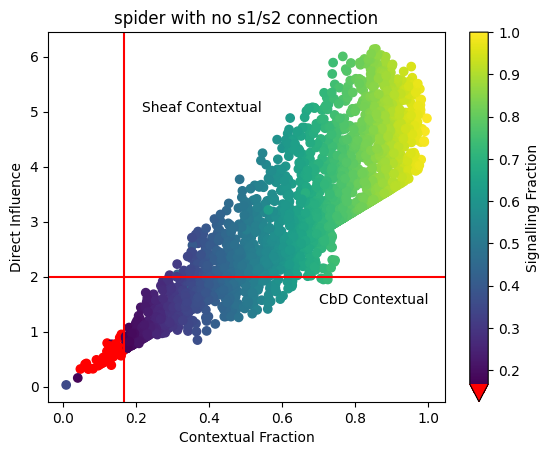

In [56]:
scenario_442_skip.plot_cnxt(title="spider with no s1/s2 connection", save=True)

In [57]:
scenario_442_spider = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                     model_path='runs/spider_200epochs/best_model.lt')

In [58]:
scenario_442_spider.get_data('dataset/contextuality_data/scenario422_spider_3057.csv')

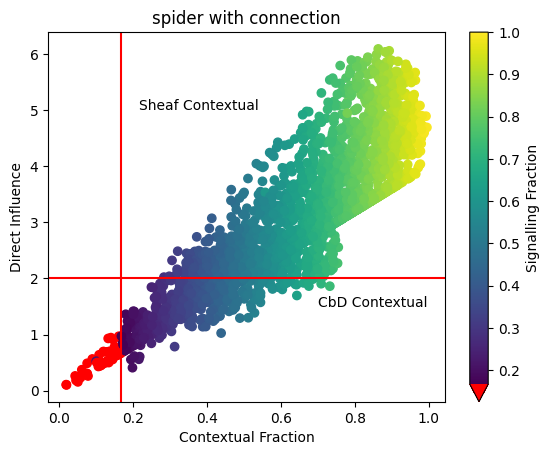

In [59]:
scenario_442_spider.plot_cnxt(title="spider with connection", save=True)

In [60]:
scenario_442_disjoint = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                     model_path='runs/disjoint_130epoches/best_model.lt')

In [61]:
scenario_442_disjoint.get_data('dataset/contextuality_data/scenario442_disjoint_3057.csv')

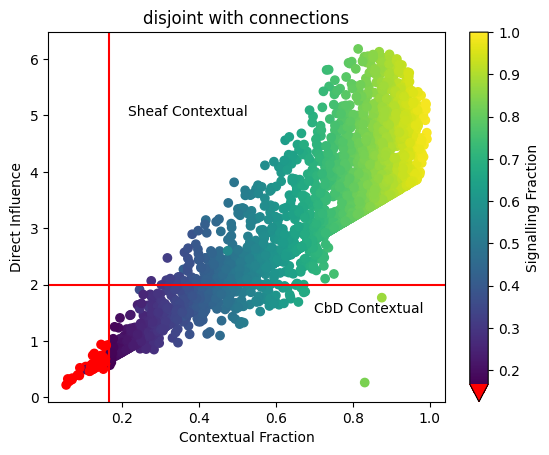

In [62]:
scenario_442_disjoint.plot_cnxt(title="disjoint with connections", save=True)

In [142]:
models = {'disjoint': 'runs/disjoint_130epoches/best_model.lt', 
          'spider': 'runs/spider_200epochs/best_model.lt', 
          'skip': 'runs/skip_60epochs/best_model.lt'}

data = {'disjoint': 'dataset/contextuality_data/scenario442_disjoint_3057.csv',
        'spider': 'dataset/contextuality_data/scenario422_spider_3057.csv',
        'skip': 'dataset/contextuality_data/scenario442_skip_3057.csv'}

In [149]:
test = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                      model_path=models['disjoint'])

In [150]:
test.get_data(data['disjoint'])

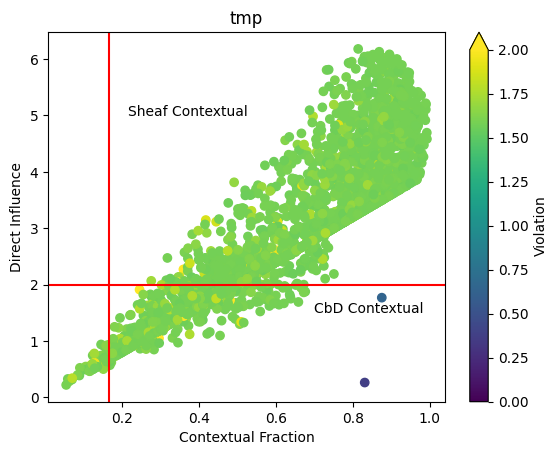

In [151]:
test.test_plot('tmp')